In [ ]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

In [ ]:
using LinearAlgebra
using Plots
using SparseArrays
using ForwardDiff
using ControlSystems
using OSQP

In [ ]:
#Model parameters
g = 9.81 #m/s^2
m = 1.0 #kg 
ℓ = 0.3 #meters
J = 0.2*m*ℓ*ℓ

#Thrust limits
umin = [0.2*m*g; 0.2*m*g]
umax = [0.6*m*g; 0.6*m*g]

h = 0.05 #time step (20 Hz)

In [ ]:
#Planar Quadrotor Dynamics
function quad_dynamics(x,u)
    θ = x[3]
    
    ẍ = (1/m)*(u[1] + u[2])*sin(θ)
    ÿ = (1/m)*(u[1] + u[2])*cos(θ) - g
    θ̈ = (1/J)*(ℓ/2)*(u[2] - u[1])
    
    return [x[4:6]; ẍ; ÿ; θ̈]
end

In [ ]:
function quad_dynamics_rk4(x,u)
    
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)

    return x + (h/6)*(f1+2*f2+2*f3+f4)
end

In [ ]:
#Linearized dynamics for hovering
x_hover = [ 0; 0; 0; 0; 0; 0 ]
u_hover = [ 0.5*m*g; 0.5*m*g ]
A = ForwardDiff.jacobian(x -> quad_dynamics(x, u_hover), x_hover)
B = ForwardDiff.jacobian(u -> quad_dynamics(x_hover, u), u_hover)
quad_dynamics_rk4(x_hover, u_hover)

In [ ]:
Nx = 6     # number of state
Nu = 2     # number of controls
Tfinal = 10.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));

In [1]:
# Cost weights
Q = Array(1.0*I(Nx))
R = Array(0.01*I(Nu))
Qn = Array(1.0*I(Nx))

LoadError: UndefVarError: I not defined

In [2]:
#Cost function
function cost(xhist,uhist)
    J = 0.5 * (xhist[:,end])' * Qn * (xhist[:,end])

    for k in 1:(size(xhist, 2)-1)
        J = J + 0.5 * (xhist[:,k])' * Q * (xhist[:,k]) + 0.5 * (uhist[:,k])' * R * (uhist[:,k])[1]
    end

    return J
end

cost (generic function with 1 method)

## LQR Hover Controller

In [3]:
K = dlqr(A, B, Q, R)
P = dare(A, B, Q, R)

function lqr_controller(t,x,K,xref)
    return u_hover - K*(x - xref)
end

LoadError: UndefVarError: dlqr not defined

## MPC Controller

In [4]:
Nh = 20 #one second horizon at 20Hz
Nx = 6
Nu = 2

2

### Case1. $z^T = [ u, x, u, x, u, x, ... , u_{N-1}, x_n ]$

In [5]:
U = kron(Diagonal(I,Nh), [I zeros(Nu,Nx)]) #Matrix that picks out all u
Θ = kron(Diagonal(I,Nh), [0 0 0 0 1 0 0 0]) #Matrix that picks out all x3 (θ)
H = sparse([kron(Diagonal(I,Nh-1),[R zeros(Nu,Nx); zeros(Nx,Nu) Q]) zeros((Nx+Nu)*(Nh-1), Nx+Nu); zeros(Nx+Nu,(Nx+Nu)*(Nh-1)) [R zeros(Nu,Nx); zeros(Nx,Nu) P]])
b = zeros(Nh*(Nx+Nu))
C = sparse([[B -I zeros(Nx,(Nh-1)*(Nu+Nx))]; zeros(Nx*(Nh-1),Nu) [kron(Diagonal(I,Nh-1), [A B]) zeros((Nh-1)*Nx,Nx)] + [zeros((Nh-1)*Nx,Nx) kron(Diagonal(I,Nh-1),[zeros(Nx,Nu) Diagonal(-I,Nx)])]])

#Dynamics + Thrust limit constraints
#D = [C; U]
#lb = [zeros(Nx*Nh); kron(ones(Nh),umin-u_hover)]
#ub = [zeros(Nx*Nh); kron(ones(Nh),umax-u_hover)]

#Dynamics + thrust limit + bound constraint on θ to keep the system within small-angle approximation
D = [C; U; Θ]
lb = [zeros(Nx*Nh); kron(ones(Nh),umin-u_hover); -0.2*ones(Nh)]
ub = [zeros(Nx*Nh); kron(ones(Nh),umax-u_hover); 0.2*ones(Nh)]

prob = OSQP.Model()
OSQP.setup!(prob; P=H, q=b, A=D, l=lb, u=ub, verbose=false, eps_abs=1e-8, eps_rel=1e-8, polish=1);

LoadError: UndefVarError: Diagonal not defined

In [6]:
function mpc_controller_case1(t,x,xref)
    
    #Update QP problem
    lb[1:6] .= -A*x
    ub[1:6] .= -A*x
    
    for j = 1:(Nh-1)
        b[(Nu+(j-1)*(Nx+Nu)).+(1:Nx)] .= -Q*xref
    end
    b[(Nu+(Nh-1)*(Nx+Nu)).+(1:Nx)] .= -P*xref
    
    OSQP.update!(prob, q=b, l=lb, u=ub)

    #Solve QP
    results = OSQP.solve!(prob)
    Δu = results.x[1:Nu]

    return u_hover + Δu
end

mpc_controller_case1 (generic function with 1 method)

### Case2. $z^T = [ x, x, x, ... ,x_N, u, u, u ... , u_{N-1} ]$

In [67]:
H = blockdiag( sparse(kron(Diagonal(I,Nh), Q)), sparse(Qn), sparse(kron(Diagonal(I,Nh), R)) )
b = zeros(Nh*(Nx+Nu)+Nx)

C_left = sparse(kron(Diagonal(I,Nh+1), -I(Nx)) + [zeros(Nx, Nx*(Nh)) zeros(Nx, Nx); kron(Diagonal(I,Nh), A) zeros(Nx*(Nh), Nx)])
C_right = [ zeros(Nx, Nu*Nh); kron(Diagonal(I, Nh), B) ]
C = [C_left C_right]
U = [zeros(Nu*Nh, Nx*(Nh+1)) kron(Diagonal(I, Nh), I(2))]

D = [C; U]
lb = [zeros(Nx*(Nh+1)); kron(ones(Nh), umin-u_hover)]
ub = [zeros(Nx*(Nh+1)); kron(ones(Nh), umax-u_hover)]

prob = OSQP.Model()
OSQP.setup!(prob; P=H, q=b, A=D, l=lb, u=ub, verbose=false, eps_abs=1e-8, eps_rel=1e-8, polish=1);

In [69]:
function mpc_controller_case2(t,x,xref)
    
    #Update QP problem
    lb[1:Nx] .= -A*x
    ub[1:Nx] .= -A*x
    
    for j = 1:Nh
        b[((Nx)*(j-1)).+(1:Nx)] .= -Q*xref
    end
    b[(Nh*Nx).+(1:Nx)] .= -P*xref
    
    OSQP.update!(prob, q=b, l=lb, u=ub)

    #Solve QP
    results = OSQP.solve!(prob)
    Δu = results.x[((Nh+1)*Nx).+(1:Nu)]

    return u_hover + Δu
end

mpc_controller_case2 (generic function with 1 method)

## MPC Simulation

In [71]:
function closed_loop(x0,controller,N)
    xhist = zeros(length(x0),N)
    u0 = controller(1,x0)
    uhist = zeros(length(u0),N-1)
    uhist[:,1] .= u0
    xhist[:,1] .= x0
    for k = 1:(N-1)
        uk = controller(k,xhist[:,k])
        uhist[:,k] = max.(min.(umax, uk), umin) #enforce control limits
        xhist[:,k+1] .= quad_dynamics_rk4(xhist[:,k],uhist[:,k])
    end
    return xhist, uhist
end

closed_loop (generic function with 1 method)

In [72]:
x_ref = [0.0; 1.0; 0; 0; 0; 0]
x0 = [10.0; 2.0; 0.0; 0; 0; 0]
xhist1, uhist1 = closed_loop(x0, (t,x)->lqr_controller(t,x,K,x_ref), Nt);
xhist2, uhist2 = closed_loop(x0, (t,x)->mpc_controller_case1(t,x,x_ref), Nt);

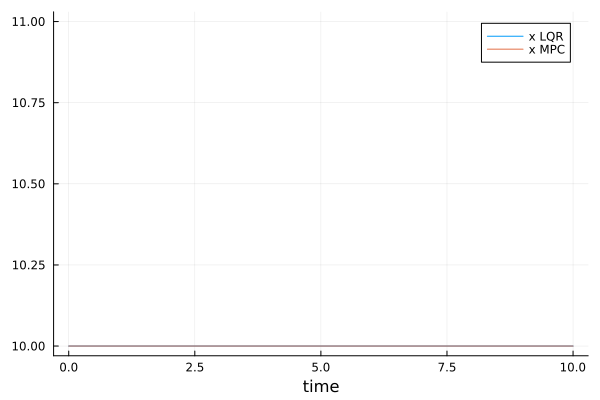

In [73]:
plot(thist,xhist1[1,:], label="x LQR")
plot!(thist,xhist2[1,:], label="x MPC")
xlabel!("time")